<a href="https://colab.research.google.com/github/FishingVil/Health-Insurance-Cross-Sell-Prediction/blob/main/Health_Insurance_Cross_Sell_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyod
!pip install kaggle
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.5 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()  # Chọn file kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"toitestcode","key":"542254d28b468a300ab95991cea35178"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction
!unzip health-insurance-cross-sell-prediction.zip


Dataset URL: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction
License(s): GPL-2.0
  0% 0.00/6.47M [00:00<?, ?B/s]
100% 6.47M/6.47M [00:00<00:00, 311MB/s]
Archive:  health-insurance-cross-sell-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Phân tích dữ liệu cơ bản**

In [57]:
import pandas as pd

#Tải dữ liệu
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Kiểm tra sơ bộ dữ liệu
train.info()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


| Biến (Variable)        | Định nghĩa (Definition)                                                                                                   |
| ---------------------- | ------------------------------------------------------------------------------------------------------------------------- |
| `id`                   | ID duy nhất của khách hàng                                                                                                |
| `Gender`               | Giới tính của khách hàng                                                                                                  |
| `Age`                  | Tuổi của khách hàng                                                                                                       |
| `Driving_License`      | 0: Khách hàng chưa có bằng lái xe, 1: Khách hàng đã có bằng lái xe                                                        |
| `Region_Code`          | Mã vùng duy nhất nơi khách hàng sinh sống                                                                                 |
| `Previously_Insured`   | 1: Khách hàng đã có bảo hiểm xe, 0: Khách hàng chưa có bảo hiểm xe                                                        |
| `Vehicle_Age`          | Tuổi của chiếc xe (ví dụ: "< 1 Year", "1-2 Year", "> 2 Years")                                                            |
| `Vehicle_Damage`       | 1: Khách hàng đã từng làm hỏng xe trong quá khứ, 0: Chưa từng làm hỏng xe                                                 |
| `Annual_Premium`       | Số tiền khách hàng phải trả hàng năm cho bảo hiểm                                                                         |
| `Policy_Sales_Channel` | Mã ẩn danh đại diện cho kênh bán hàng tiếp cận khách hàng (ví dụ: qua đại lý, email, điện thoại, gặp mặt trực tiếp, v.v.) |
| `Vintage`              | Số ngày khách hàng đã gắn bó với công ty                                                                                  |
| `Response`             | 1: Khách hàng có quan tâm đến bảo hiểm xe, 0: Không quan tâm                                                              |


In [58]:
#Kiểm tra dữ liệu bị thiếu thông tin
missing_per_column = train.isnull().sum()
print(missing_per_column)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


In [59]:
#Loại bỏ đi cột id từ dữ liệu
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

In [60]:
def plot_bar_and_percentage_table(df, column_name): # Hàm vẽ biểu đồ cột cho các biến lựa chọn
    # Tính số lượng và phần trăm
    count_series = df[column_name].value_counts()
    percent_series = df[column_name].value_counts(normalize=True) * 100
    summary_df = pd.DataFrame({
        'Số lượng': count_series,
        'Tỷ lệ (%)': percent_series.round(2)
    })

    # In bảng tỷ lệ phần trăm
    print(f"\n Bảng tần suất và tỷ lệ phần trăm cho '{column_name}':\n")
    display(summary_df)

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=column_name, data=df, palette='Set2', order=count_series.index, hue = column_name, legend = False)

    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{100 * count / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

    plt.title(f'Biểu đồ tần suất - {column_name}', fontsize=14)
    plt.ylabel('Số lượng')
    plt.xlabel(column_name)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


In [61]:
def plot_histogram(df, column_name, bins=30): # Hàm vẽ biểu đồ cho các biến liên tục
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name].dropna(), kde=False, bins=bins, color='skyblue')
    plt.title(f'Phân phối của {column_name}', fontsize=14)
    plt.xlabel(column_name)
    plt.ylabel('Tần suất')
    plt.tight_layout()
    plt.show()


 Bảng tần suất và tỷ lệ phần trăm cho 'Gender':



,Số lượng,Tỷ lệ (%)
Gender,,
Male,206089,54.08
Female,175020,45.92


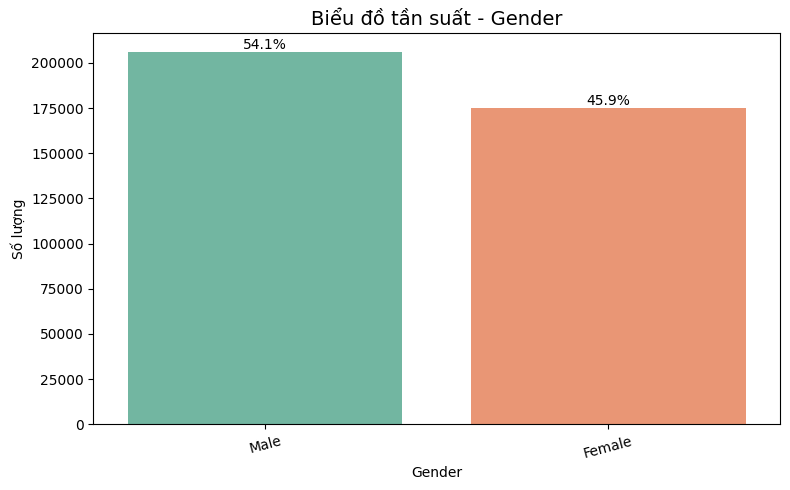


 Bảng tần suất và tỷ lệ phần trăm cho 'Driving_License':



,Số lượng,Tỷ lệ (%)
Driving_License,,
1,380297,99.79
0,812,0.21


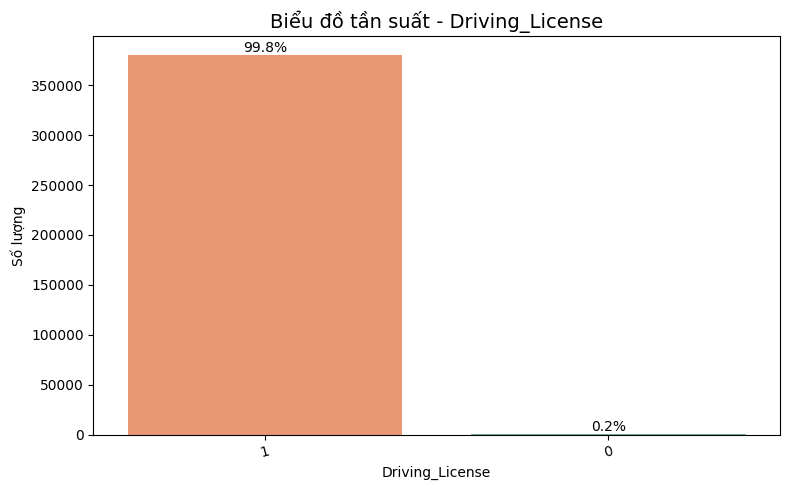


 Bảng tần suất và tỷ lệ phần trăm cho 'Previously_Insured':



,Số lượng,Tỷ lệ (%)
Previously_Insured,,
0,206481,54.18
1,174628,45.82


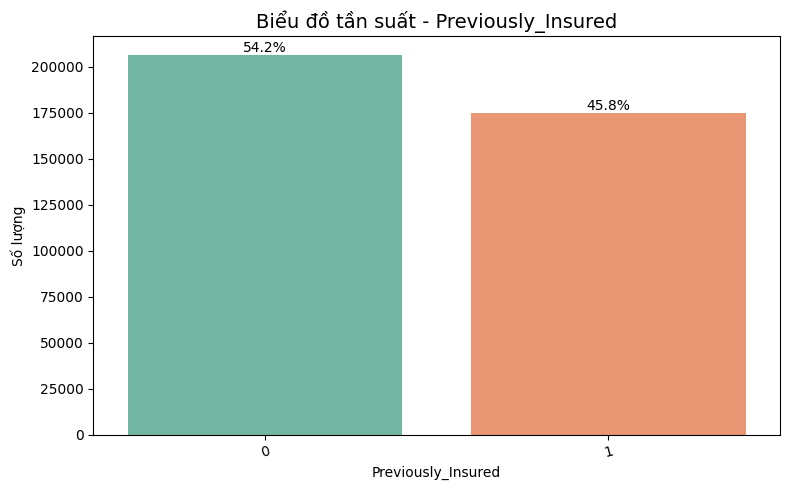


 Bảng tần suất và tỷ lệ phần trăm cho 'Vehicle_Age':



,Số lượng,Tỷ lệ (%)
Vehicle_Age,,
1-2 Year,200316,52.56
< 1 Year,164786,43.24
> 2 Years,16007,4.20


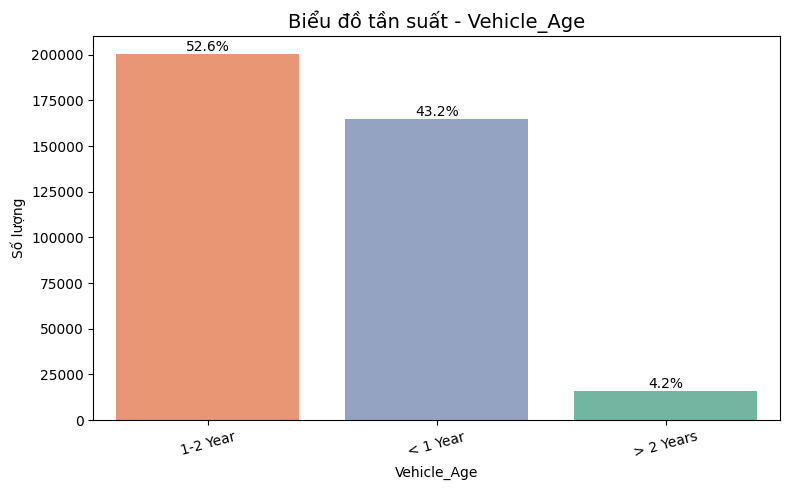


 Bảng tần suất và tỷ lệ phần trăm cho 'Vehicle_Damage':



,Số lượng,Tỷ lệ (%)
Vehicle_Damage,,
Yes,192413,50.49
No,188696,49.51


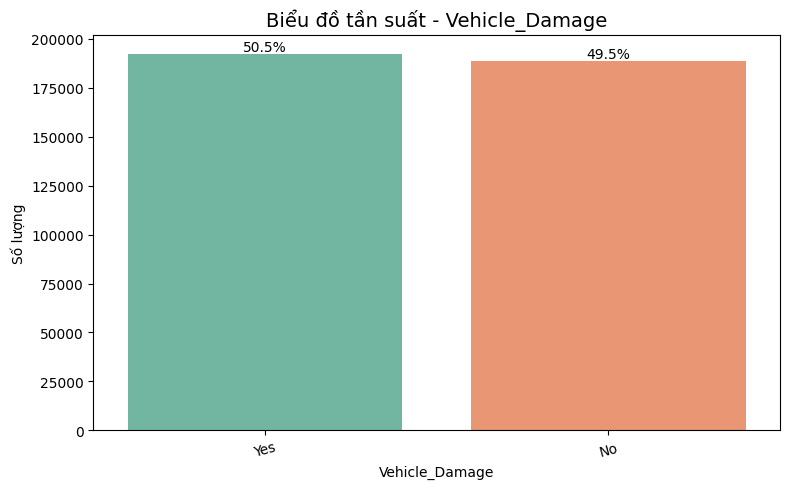


 Bảng tần suất và tỷ lệ phần trăm cho 'Response':



,Số lượng,Tỷ lệ (%)
Response,,
0,334399,87.74
1,46710,12.26


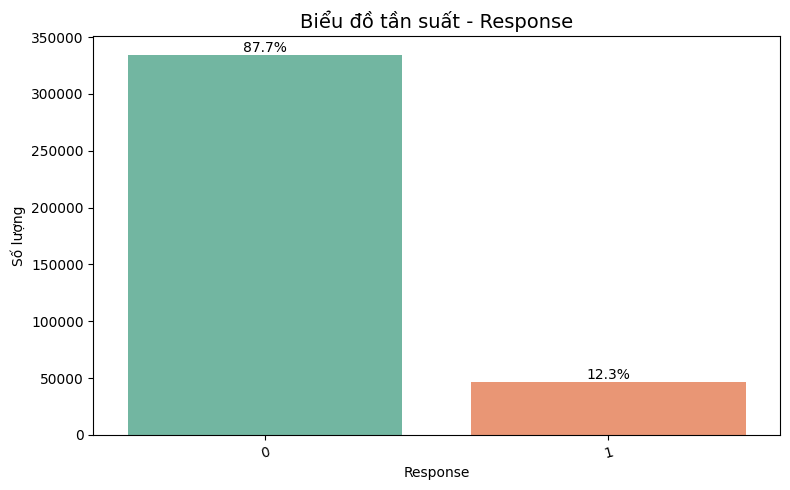


 Bảng tần suất và tỷ lệ phần trăm cho 'Region_Code':



,Số lượng,Tỷ lệ (%)
Region_Code,,
28.0,106415,27.92
8.0,33877,8.89
46.0,19749,5.18
41.0,18263,4.79
15.0,13308,3.49
30.0,12191,3.20
29.0,11065,2.90
50.0,10243,2.69
3.0,9251,2.43


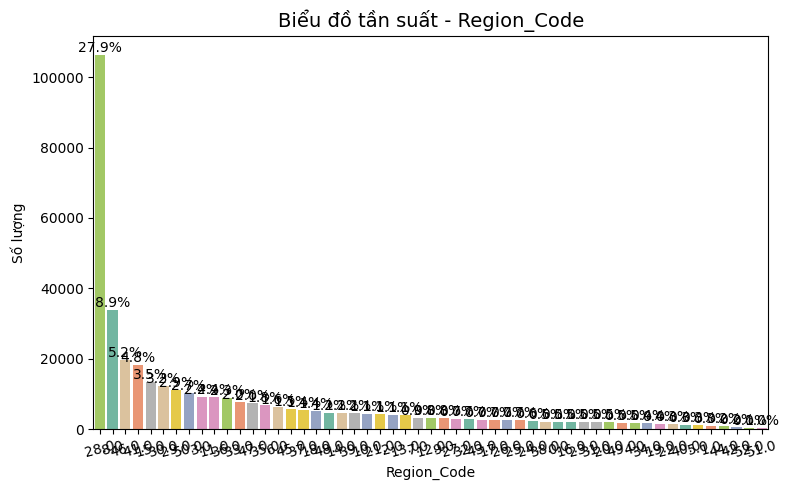


 Bảng tần suất và tỷ lệ phần trăm cho 'Policy_Sales_Channel':



,Số lượng,Tỷ lệ (%)
Policy_Sales_Channel,,
152.0,134784,35.37
26.0,79700,20.91
124.0,73995,19.42
160.0,21779,5.71
156.0,10661,2.80
...,...,...
149.0,1,0.00
43.0,1,0.00
144.0,1,0.00


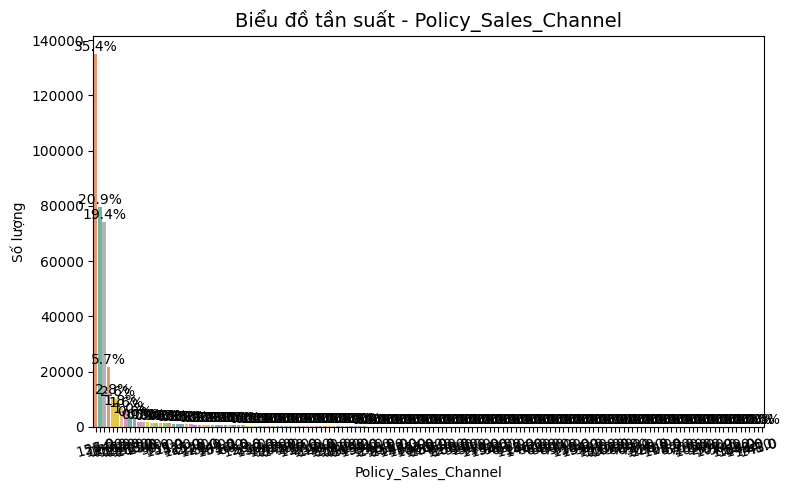

In [62]:
columns_to_plot = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Response', 'Region_Code', 'Policy_Sales_Channel']

for col in columns_to_plot:
    plot_bar_and_percentage_table(train,col)


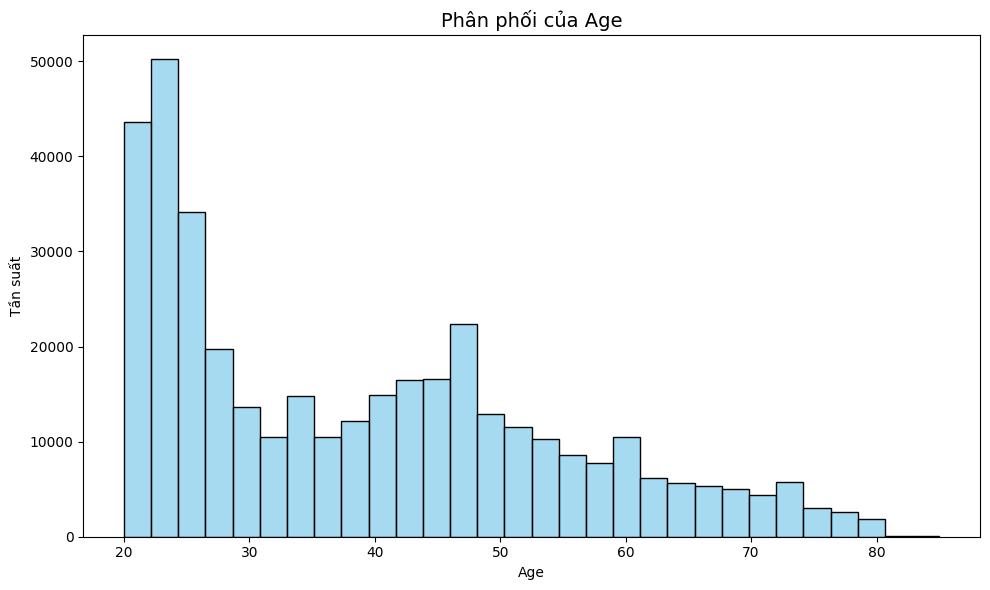

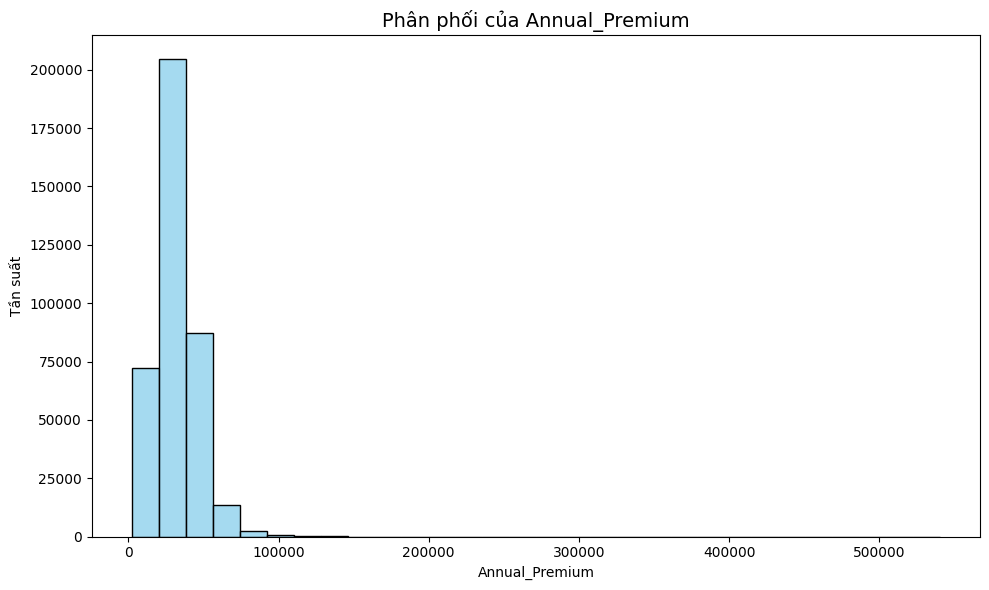

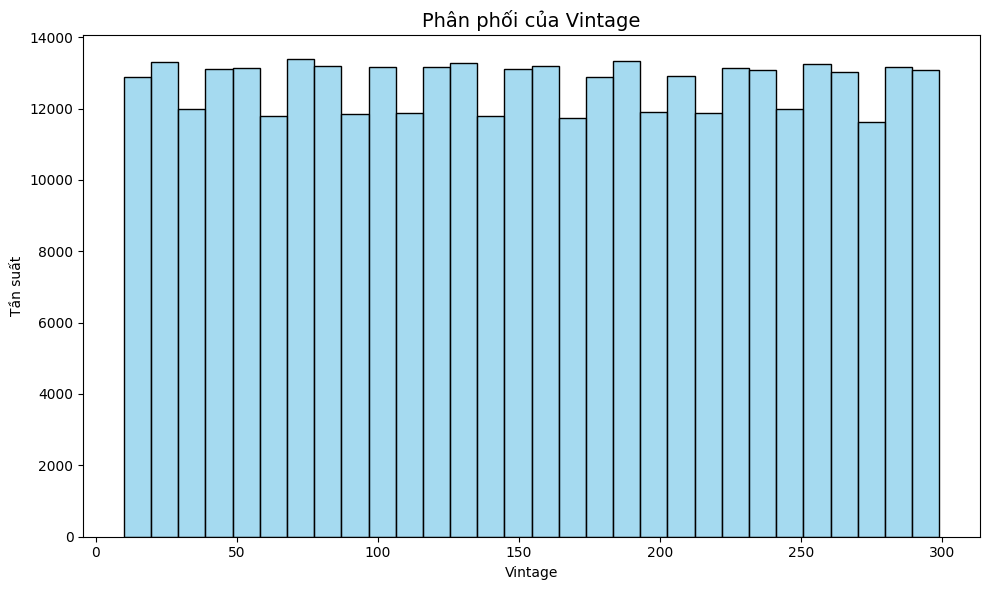

In [63]:
numerical_columns = ['Age', 'Annual_Premium', 'Vintage']

for col in numerical_columns:
    plot_histogram(train, col)

In [64]:
bins = list(range(20, 100, 10))  # Chia các khoảng: 20-29, 30-39, ..., 90-99
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Tạo cột mới là 'Age_Group'
train['Age_Group'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

# Tính số lượng và tỉ lệ phần trăm
age_counts = train['Age_Group'].value_counts().sort_index()
age_percent = (age_counts / len(train) * 100).round(2)

# In kết quả
age_summary = pd.DataFrame({'Số lượng': age_counts, 'Tỉ lệ (%)': age_percent})
print(age_summary)


           Số lượng  Tỉ lệ (%)
Age_Group                     
20-29        155203      40.72
30-39         54253      14.24
40-49         76846      20.16
50-59         48034      12.60
60-69         29023       7.62
70-79         16712       4.39
80-89          1038       0.27


In [65]:
data = train['Annual_Premium']
bins = 30  # hoặc số bin bạn muốn

# Tính toán histogram
counts, bin_edges = np.histogram(data, bins=bins)

# Tìm bin có tần suất cao nhất
max_idx = np.argmax(counts)
a = round(bin_edges[max_idx])
b = round(bin_edges[max_idx + 1])
max_count = int(counts[max_idx])

print(f'Khoảng có tần suất cao nhất: ({a}, {b}) với {max_count} khách hàng')


Khoảng có tần suất cao nhất: (20548, 38466) với 204503 khách hàng


# Từ thống kê sơ bộ ta thấy

* Giới tính khách hàng là nam và nữ không chênh lệch quá nhiều

* Gần như toàn bộ các khách hàng đều có bằng lái xe
* Hơn phân nửa là khách hàng đã từng mua bảo hiểm xe


* Phần lớn tuổi thọ xe của khách hàng là dưới 2 năm, chỉ có khoảng 4.2% khách hàng có xe tuổi thọ trên 2 năm


* Số lượng khách hàng từng bị hỏng xe chiếm khoảng 1 nửa
* Khách hàng phần lớn nằm ở độ tuổi từ 20-29 chiếm đến 40.72% , ở độ tuổi từ 40-49 khách hàng cũng chiếm khá nhiều đến 20.16%
* Khoảng có tần suất cao nhất: (20548, 38466) với 204503 khách hàng
* Thời gian khách hàng gắn bó với công ty phân bố khá đồng đều
* Các kênh tiếp cận khách hàng nhiều nhất là 152, 26, 124
* Có tới 87.7% khách hàng không có hứng thú tới việc sẽ mua bảo hiểm xe
* Bộ dữ liệu bị mất cân bằng về dữ liệu tỉ lệ người không quan tâm mua bảo hiểm 87.74%, trong khi người quan tâm mua bảo hiểm chỉ có 12.26%



In [66]:
def plot_grouped_count_and_percentage_table(df, category_col, response_col='Response'):
    # Đếm số lượng theo nhóm và response
    count_data = df.groupby([category_col, response_col]).size().reset_index(name='Count')

    # Tổng số mỗi nhóm
    total_per_group = df.groupby(category_col).size().reset_index(name='Total')

    # Gộp để tính phần trăm
    merged = pd.merge(count_data, total_per_group, on=category_col)
    merged['Percentage'] = (merged['Count'] / merged['Total'] * 100).round(1)

    # Vẽ biểu đồ cột theo số lượng
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=merged, x=category_col, y='Count', hue=response_col, palette='Set2')

    # Ghi số lượng lên mỗi cột
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9)

    plt.title(f'Số lượng theo {category_col} và {response_col}')
    plt.ylabel('Số lượng')
    plt.xlabel(category_col)
    plt.legend(title=response_col)
    plt.tight_layout()
    plt.show()

    # Hiển thị bảng phần trăm
    pivot = merged.pivot(index=category_col, columns=response_col, values='Percentage')
    pivot.columns = [f'{response_col}={col}' for col in pivot.columns]
    display(pivot)


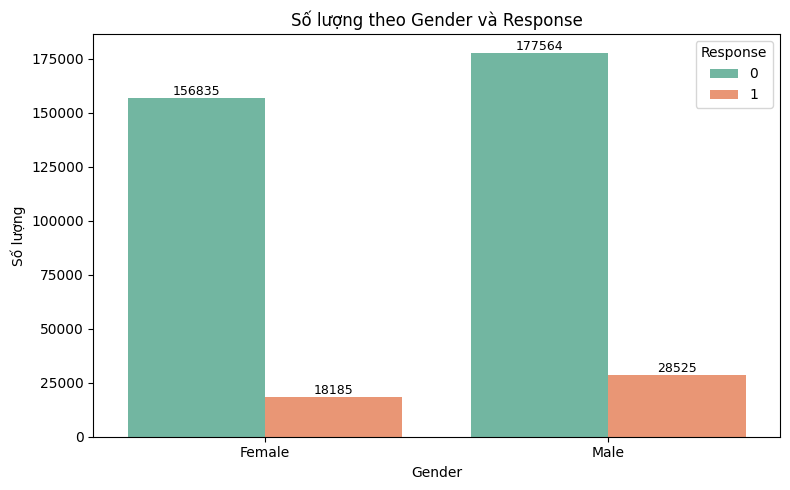

,Response=0,Response=1
Gender,,
Female,89.6,10.4
Male,86.2,13.8


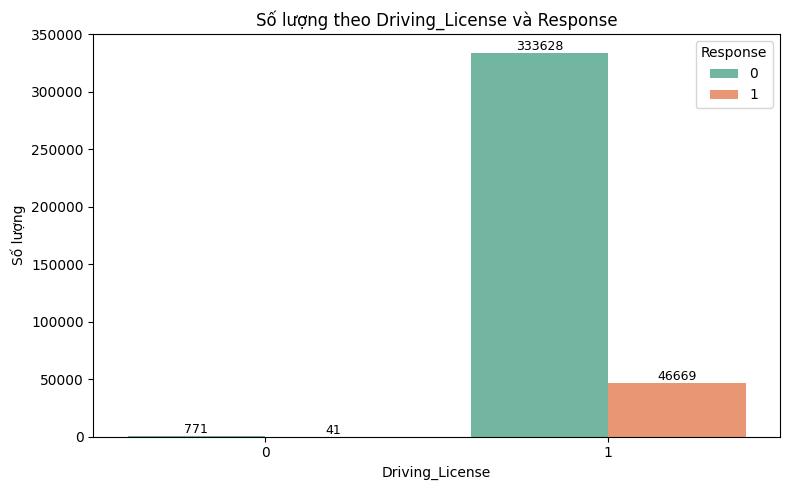

,Response=0,Response=1
Driving_License,,
0,95.0,5.0
1,87.7,12.3


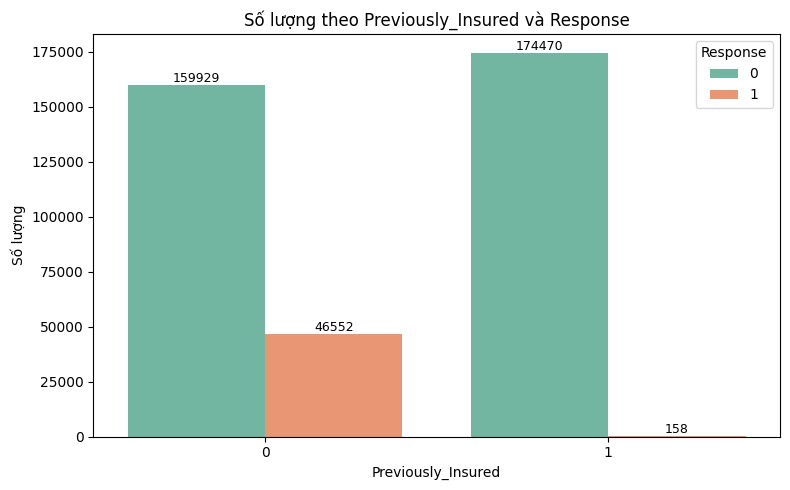

,Response=0,Response=1
Previously_Insured,,
0,77.5,22.5
1,99.9,0.1


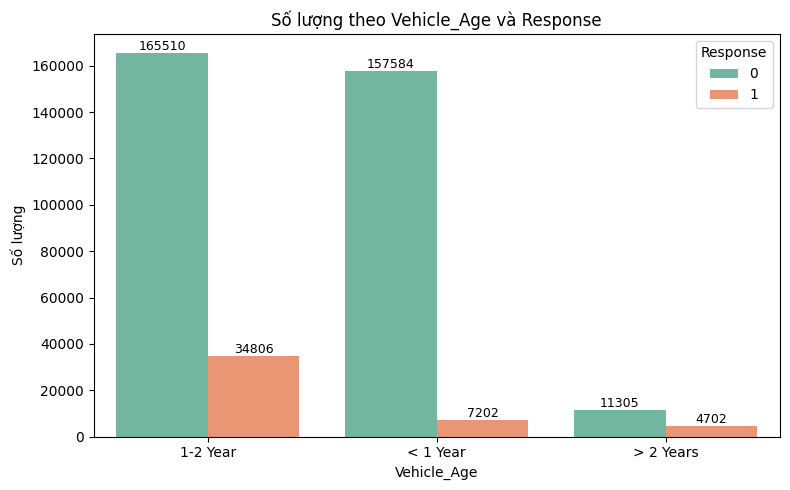

,Response=0,Response=1
Vehicle_Age,,
1-2 Year,82.6,17.4
< 1 Year,95.6,4.4
> 2 Years,70.6,29.4


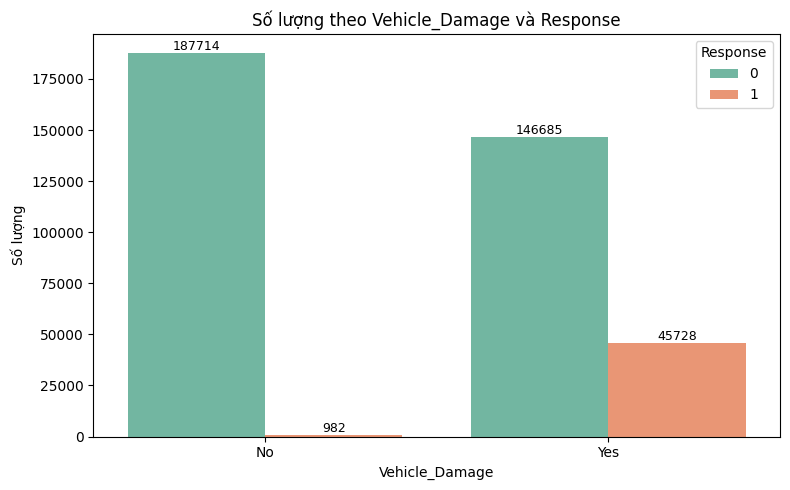

,Response=0,Response=1
Vehicle_Damage,,
No,99.5,0.5
Yes,76.2,23.8


In [67]:
columnWithRespone_to_plot = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Response',]

for col in columnWithRespone_to_plot:
    if col != 'Response':
      plot_grouped_count_and_percentage_table(train,col)


In [68]:
def plot_histogram_by_response(df, continuous_col, response_col='Response', bins=30):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 5))

    # Vẽ histogram phân nhóm theo response
    for response_value in sorted(df[response_col].unique()):
        subset = df[df[response_col] == response_value]
        sns.histplot(subset[continuous_col], bins=bins, label=f'{response_col}={response_value}', kde=False, element='step', stat='count')

    plt.title(f'Phân phối {continuous_col} theo {response_col}')
    plt.xlabel(continuous_col)
    plt.ylabel('Số lượng')
    plt.legend()
    plt.tight_layout()
    plt.show()


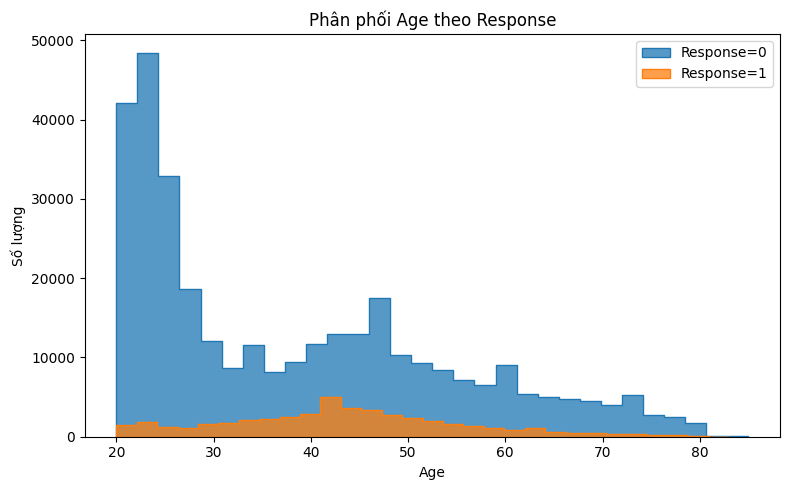

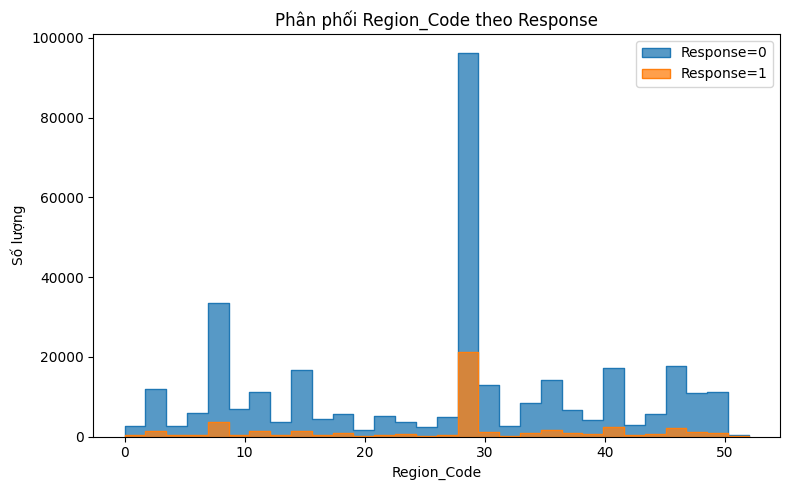

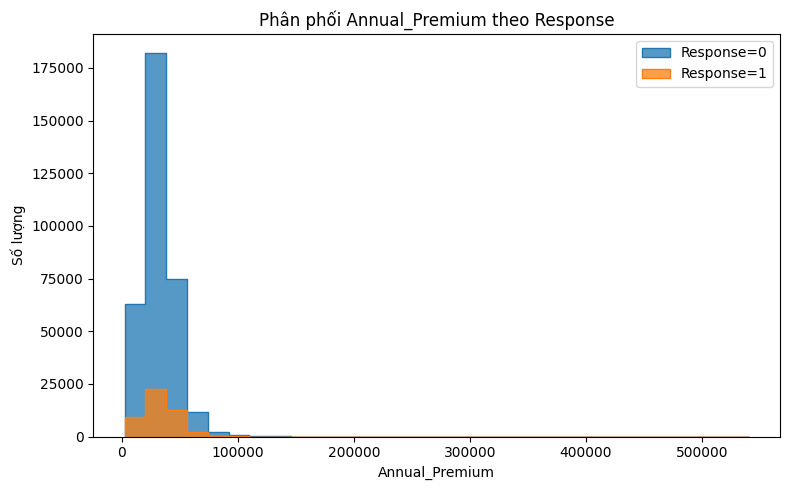

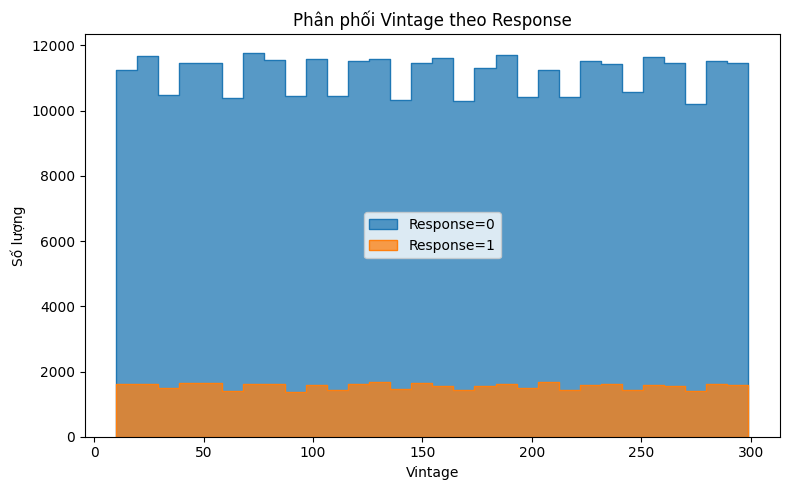

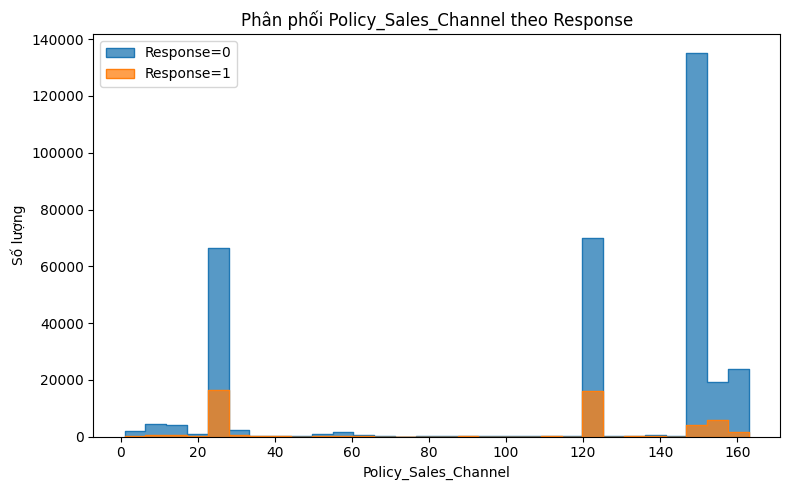

In [69]:
numerical_columns = ['Age','Region_Code', 'Annual_Premium', 'Vintage', 'Policy_Sales_Channel']

for col in numerical_columns:
    plot_histogram_by_response(train, col)

In [70]:
train['Response'].value_counts()


,count
Response,
0,334399
1,46710


# Đối chiếu từng đặc điểm với việc có quan tâm đến mua bảo hiểm xe



*   Qua việc thống kê sơ bộ ở trên ta có thể thấy dường như những người sở hữu xe trên 2 năm và những người từng bị thiệt hại về xe thì sẽ quan tâm tới việc mua bảo hiểm xe hơn

*   Độ tuổi 40-45 có tỉ lệ cao về việc quan tâm tới mua bảo hiểm xe

*  2 kênh có số khách hàng có xu hướng mua bảo hiểm khá cao là 26 và 124

* Các đặc trưng khác tỉ lệ khá đồng đều với nhau không lệch về bên nào nên ta chưa thể xem sự phản ảnh của chúng



# **Tạo đặc trưng cho dữ liệu**

In [71]:
#label encoding
train.loc[train['Gender'] == 'Male', 'Gender'] = 1
train.loc[train['Gender'] == 'Female', 'Gender'] = 0
test.loc[test['Gender'] == 'Male', 'Gender'] = 1
test.loc[test['Gender'] == 'Female', 'Gender'] = 0

train.loc[train['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
train.loc[train['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
train.loc[train['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
test.loc[test['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
test.loc[test['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
test.loc[test['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0

train.loc[train['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
train.loc[train['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0
test.loc[test['Vehicle_Damage'] == 'Yes', 'Vehicle_Damage'] = 1
test.loc[test['Vehicle_Damage'] == 'No', 'Vehicle_Damage'] = 0

In [72]:
train.drop('Age_Group', axis=1, inplace=True)

In [73]:
for col in train.columns:
    train[col] = train[col].astype(np.int32)

train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28,0,2,1,40454,26,217,1
1,1,76,1,3,0,1,0,33536,26,183,0
2,1,47,1,28,0,2,1,38294,26,27,1
3,1,21,1,11,1,0,0,28619,152,203,0
4,0,29,1,41,1,0,0,27496,152,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26,1,1,0,30170,26,88,0
381105,1,30,1,37,1,0,0,40016,152,131,0
381106,1,21,1,30,1,0,0,35118,160,161,0
381107,0,68,1,14,0,2,1,44617,124,74,0


In [74]:
def plot_correlation_matrix(df, method='pearson', annot=True, cmap='coolwarm', figsize=(10, 8)):
    plt.figure(figsize=figsize)

    # Chỉ lấy các cột số
    numeric_df = df.select_dtypes(include=['number'])

    # Tính ma trận tương quan
    corr = numeric_df.corr(method=method)

    # Vẽ heatmap
    sns.heatmap(corr, annot=annot, fmt=".2f", cmap=cmap, square=True, linewidths=.5)
    plt.title('Ma trận tương quan giữa các biến số', fontsize=14)
    plt.tight_layout()
    plt.show()

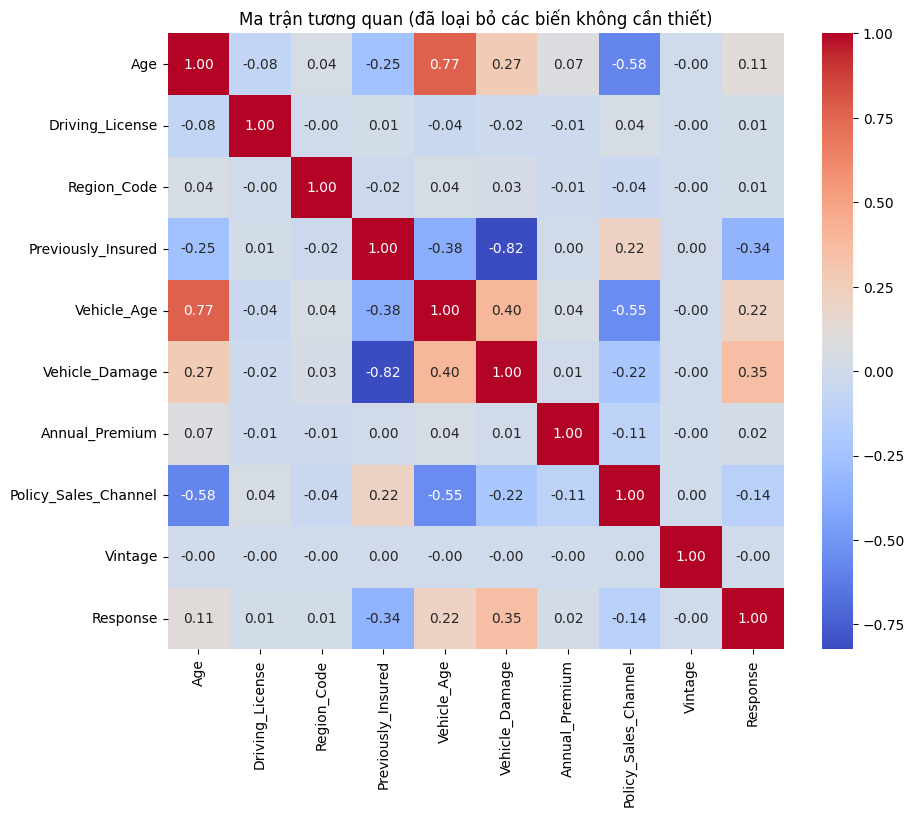

In [75]:
cols_to_remove = ['Gender']

df_encoded = train.copy()
# Loại bỏ các biến đó (nếu tồn tại)
df_filtered = df_encoded.drop(columns=[col for col in cols_to_remove if col in df_encoded.columns])

# Tính ma trận tương quan
corr_matrix = df_filtered.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Ma trận tương quan (đã loại bỏ các biến không cần thiết)')
plt.show()

In [76]:
for col in train.columns:
    if col != 'Response' and col != 'Gender':
      print(col, train[col].corr(train['Response']))

Age 0.11114689471251019
Driving_License 0.01015517459407371
Region_Code 0.01056985561522313
Previously_Insured -0.34117046261352385
Vehicle_Age 0.2218739872179906
Vehicle_Damage 0.35439954387975453
Annual_Premium 0.022574695542560037
Policy_Sales_Channel -0.139041500829161
Vintage -0.0010503720019898887


# Xây dựng mô hình

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from pyod.models.copod import COPOD
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [78]:
X = train.drop(['Response'], axis=1)
y = train['Response']

In [79]:
kmeans = KMeans(
    n_clusters=2,
    random_state=30
).fit(X)

In [80]:
train['cluster'] = kmeans.labels_
train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,cluster
0,1,44,1,28,0,2,1,40454,26,217,1,0
1,1,76,1,3,0,1,0,33536,26,183,0,0
2,1,47,1,28,0,2,1,38294,26,27,1,0
3,1,21,1,11,1,0,0,28619,152,203,0,0
4,0,29,1,41,1,0,0,27496,152,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26,1,1,0,30170,26,88,0,0
381105,1,30,1,37,1,0,0,40016,152,131,0,0
381106,1,21,1,30,1,0,0,35118,160,161,0,0
381107,0,68,1,14,0,2,1,44617,124,74,0,0


In [81]:
train['cluster'].value_counts()

,count
cluster,
0,309277
1,71832


In [82]:
print('Kmeans accuracy: ', accuracy_score(train['Response'], train['cluster']))
print('Kmeans f1_score: ', f1_score(train['Response'], train['cluster']))

Kmeans accuracy:  0.7365373160959201
Kmeans f1_score:  0.15297531676536585


In [83]:
response = train['Response']
train = train.drop(['Response', 'cluster'], axis=1)

In [84]:
clf = COPOD(
    contamination=0.15
)
clf.fit(train)

COPOD(contamination=0.15, n_jobs=1)

In [85]:
cluster = clf.predict(train)
train['cluster'] = cluster
train['Response'] = response
train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,cluster,Response
0,1,44,1,28,0,2,1,40454,26,217,0,1
1,1,76,1,3,0,1,0,33536,26,183,1,0
2,1,47,1,28,0,2,1,38294,26,27,0,1
3,1,21,1,11,1,0,0,28619,152,203,0,0
4,0,29,1,41,1,0,0,27496,152,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26,1,1,0,30170,26,88,0,0
381105,1,30,1,37,1,0,0,40016,152,131,0,0
381106,1,21,1,30,1,0,0,35118,160,161,0,0
381107,0,68,1,14,0,2,1,44617,124,74,1,0


In [86]:
train['cluster'].value_counts()

,count
cluster,
0,323942
1,57167


In [87]:
print('COPOD accuracy: ', accuracy_score(train['Response'], train['cluster']))
print('COPOD f1_score: ', f1_score(train['Response'], train['cluster']))

COPOD accuracy:  0.7634246370460944
COPOD f1_score:  0.1320407789982383


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [89]:
print('Positive cases % in validation set: ', round(100 * len(y_test[y_test == 1]) / len(y_test), 3), '%')
print('Positive cases % in train set: ', round(100 * len(y_train[y_train == 1]) / len(y_train), 3), '%')

Positive cases % in validation set:  12.343 %
Positive cases % in train set:  12.235 %


Tỉ lệ khách hàng khả năng mua bảo hiểm ở 2 tập train và test đều xấp xỉ nhau nên ta có thể sử dụng tập test để kiểm tra mô hình

# Logistic Regression


In [90]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=666,class_weight='balanced')
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=666)

In [91]:
preds = model.predict(X_test_scaled)
print('Simple Logistic Regression accuracy: ', accuracy_score(y_test, preds))
print('Simple Logistic Regression f1_score: ', f1_score(y_test, preds))

Simple Logistic Regression accuracy:  0.6409829183175462
Simple Logistic Regression f1_score:  0.40208010138309264


In [92]:
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

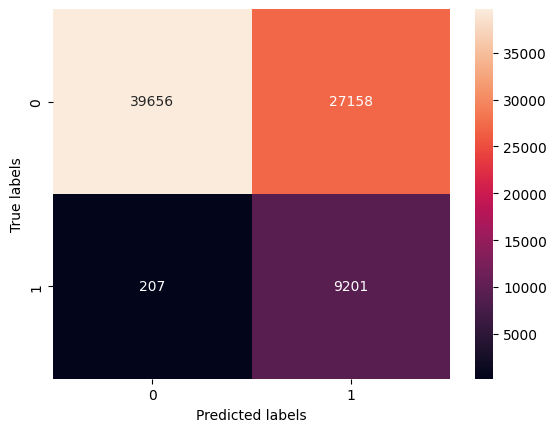

In [93]:
plot_confusion_matrix(y_test, preds)

In [94]:
X_train = X_train.drop(['Gender','Region_Code', 'Vintage', 'Driving_License'], axis=1)
X_test = X_test.drop(['Gender','Region_Code', 'Vintage', 'Driving_License'], axis=1)

In [95]:
scaler = StandardScaler()
X_train_scaled_after = scaler.fit_transform(X_train)
X_test_scaled_after = scaler.transform(X_test)

model = LogisticRegression(random_state=666,class_weight='balanced')
model.fit(X_train_scaled_after, y_train)

LogisticRegression(class_weight='balanced', random_state=666)

In [96]:
preds = model.predict(X_test_scaled_after)
print('Simple Logistic Regression accuracy: ', accuracy_score(y_test, preds))
print('Simple Logistic Regression f1_score: ', f1_score(y_test, preds))

Simple Logistic Regression accuracy:  0.639789037285823
Simple Logistic Regression f1_score:  0.4014388489208633


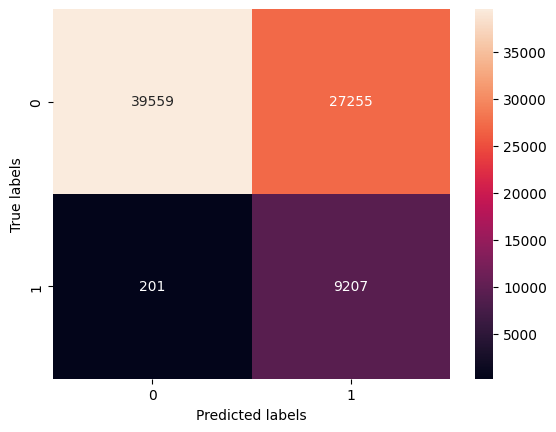

In [97]:
plot_confusion_matrix(y_test, preds)